In [1]:
%pylab inline
import xgboost as xgb
import pandas as pd
import seaborn as sns
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.linear_model import LogisticRegression
import sys
from sklearn.model_selection import train_test_split
#imports the own created package
from sklearn.tree import export_graphviz
import clustering as cl
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
sns.set(style='whitegrid', rc={'figure.figsize':(11.7,8.27)})
sns.set_context('talk', rc={ 'lines.linewidth': 6}, font_scale=1.5)

In [3]:
X_with_columns = pd.read_pickle("./X.pkl")
Z_with_columns = pd.read_pickle("./Z.pkl")

columns_to_drop = []

X_with_columns.drop(columns_to_drop, axis = 1, inplace=True)
Z_with_columns.drop(columns_to_drop, axis = 1, inplace=True)

X = np.array(X_with_columns)
Y = np.array(pd.read_pickle("./Y.pkl"))
Z = np.array(Z_with_columns)
df_next_games = pd.read_pickle("./next_games.pkl")

In [4]:
X.shape

(1430, 45)

In [5]:
kf = KFold(n_splits=4, random_state=0, shuffle=True)
kf.get_n_splits(X)

4

In [6]:
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

TRAIN: [   0    3    6 ... 1427 1428 1429] TEST: [   1    2    4    5    8    9   14   18   19   27   29   31   34   39
   40   44   45   47   49   52   53   54   55   56   58   61   75   77
   80   85   92  108  124  140  141  142  148  152  156  159  161  175
  182  184  186  192  194  198  202  204  211  215  224  227  231  233
  240  241  247  251  253  254  260  268  270  276  278  279  295  298
  299  300  302  303  308  310  312  315  317  319  322  326  330  333
  342  353  361  362  364  376  381  390  393  399  406  408  412  416
  418  422  425  426  427  431  432  434  436  438  440  443  445  446
  452  458  459  464  465  466  467  471  472  474  479  483  486  487
  491  494  501  512  513  517  526  529  530  533  535  536  539  540
  542  548  549  554  557  563  567  569  572  575  578  579  580  583
  587  597  601  608  609  610  613  618  619  621  629  641  646  649
  651  654  655  656  657  687  695  703  704  711  712  724  729  731
  733  737  744  746  751  7

## XGBoost

In [7]:
XGB_model = xgb.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.005,  
                      colsample_bytree = 0.5,
                      subsample = 0.8,
                      objective='multi:softprob', 
                      n_estimators=1000, 
                      reg_alpha = 0.2,
                      max_depth=5, 
                      gamma=5,
                      seed=82)

In [8]:
XGB_model.fit(X_train, y_train)
y_pred = XGB_model.predict(X_test)
y_pred_train = XGB_model.predict(X_train)
accuracy = accuracy_score(y_test, y_pred)
accuracy_train = accuracy_score(y_train, y_pred_train)

## LogisticRegression

In [9]:
LR = LogisticRegression(random_state = 42)
LR.fit(X_train, y_train)
LR_y_pred = LR.predict(X_test)
LR_y_pred_train = LR.predict(X_train)
LR_accuracy = accuracy_score(y_test, LR_y_pred)
LR_accuracy_train = accuracy_score(y_train, LR_y_pred_train)


## Comparassion

In [10]:
# OVERFITTING
print("XGB train Accuracy: %.2f%%" % (accuracy_train * 100.0))
print("XGB Accuracy: %.2f%%" % (accuracy * 100.0))
print("LR train Accuracy: %.2f%%" % (LR_accuracy_train * 100.0))
print("LR Accuracy: %.2f%%" % (LR_accuracy * 100.0))

XGB train Accuracy: 71.02%
XGB Accuracy: 63.03%
LR train Accuracy: 70.27%
LR Accuracy: 68.07%


In [11]:
# F1 SCORE

In [12]:
feature_importances = sort(XGB_model.feature_importances_)
for feature_importance in feature_importances:
    # select features using threshold
    selection = SelectFromModel(XGB_model, threshold=feature_importance, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Feature Importance=%.3f, n=%d, Accuracy: %.2f%%" % (feature_importance, select_X_train.shape[1], accuracy*100.0))

Feature Importance=0.013, n=45, Accuracy: 65.55%
Feature Importance=0.014, n=44, Accuracy: 65.55%
Feature Importance=0.016, n=43, Accuracy: 65.27%
Feature Importance=0.016, n=42, Accuracy: 65.83%
Feature Importance=0.016, n=41, Accuracy: 66.11%
Feature Importance=0.016, n=40, Accuracy: 65.27%
Feature Importance=0.016, n=39, Accuracy: 64.99%
Feature Importance=0.016, n=38, Accuracy: 66.11%
Feature Importance=0.017, n=37, Accuracy: 65.27%
Feature Importance=0.017, n=36, Accuracy: 64.99%
Feature Importance=0.017, n=35, Accuracy: 66.11%
Feature Importance=0.017, n=34, Accuracy: 66.95%
Feature Importance=0.018, n=33, Accuracy: 67.23%
Feature Importance=0.018, n=32, Accuracy: 65.83%
Feature Importance=0.018, n=31, Accuracy: 65.55%
Feature Importance=0.018, n=30, Accuracy: 67.51%
Feature Importance=0.018, n=29, Accuracy: 68.07%
Feature Importance=0.019, n=28, Accuracy: 66.39%
Feature Importance=0.019, n=27, Accuracy: 67.79%
Feature Importance=0.019, n=26, Accuracy: 66.95%
Feature Importance=0

In [13]:
features_names = list(X_with_columns.columns)

In [14]:
importance = np.round(XGB_model.feature_importances_,4)
dictionary = dict(zip(features_names, importance))
sorted_dictionary=sorted(dictionary.items(), key=lambda x:x[1], reverse=True)
names=[]
values=[]
for i in range(0, len(importance)):
    print('Feature Importance: {:35} {}%'.format(
        sorted_dictionary[i][0], np.round(sorted_dictionary[i][1]*100,4))
         )
    names.append(sorted_dictionary[i][0])
    values.append(np.round(sorted_dictionary[i][1]*100,4))

Feature Importance: AVGFTHG                             4.47%
Feature Importance: AVGFTAG                             4.4%
Feature Importance: odds_ft_away_team_win               3.53%
Feature Importance: awt_3                               3.38%
Feature Importance: home_ppg                            3.37%
Feature Importance: away_ppg                            3.25%
Feature Importance: odds_ft_home_team_win               3.02%
Feature Importance: awt_4                               2.97%
Feature Importance: A_AVGFTAG_1                         2.83%
Feature Importance: H_AVGFTHG_1                         2.64%
Feature Importance: ht_3                                2.47%
Feature Importance: A_ATGDIFF_1                         2.35%
Feature Importance: A_result_1                          2.32%
Feature Importance: ht_0                                2.3%
Feature Importance: ht_2                                2.25%
Feature Importance: H_result_1                          2.25%
Feature Im

In [15]:
cum_values = np.cumsum(values)
values_over_95 = (cum_values > 95).sum()
columns_over_95 = names[-values_over_95:]
columns_over_95

['over_35_percentage_pre_match',
 'over_15_HT_FHG_percentage_pre_match',
 'odds_ft_over45',
 'odds_ft_over25']

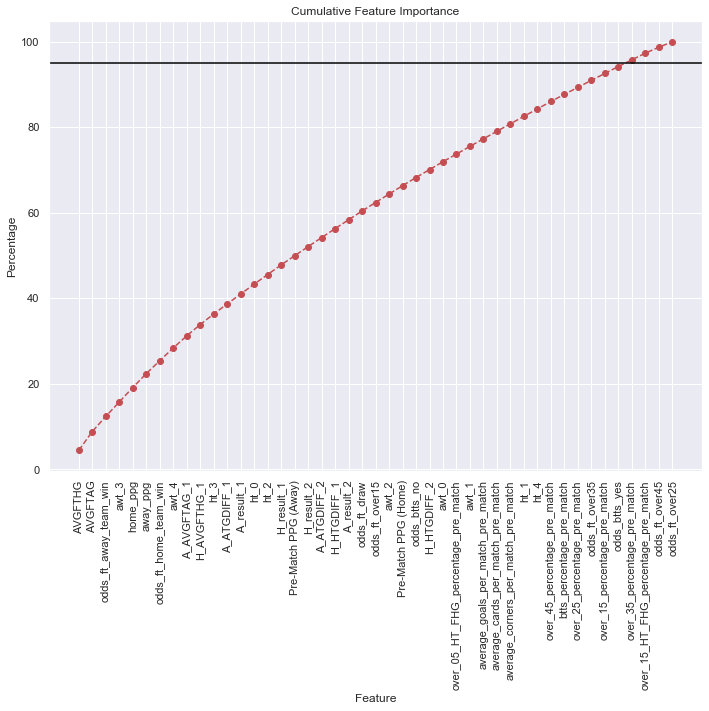

In [16]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
bottom, top = ylim()
bottom = 0
plt.plot(names,cum_values, '--bo', color='r')
# set importance at 95%
plt.axhline(95,color='black')
plt.xticks(rotation=90);
plt.xlabel('Feature'); 
plt.ylabel('Percentage'); 
plt.title('Cumulative Feature Importance');

## Predict Result for Next Games

In [17]:
z_pred = XGB_model.predict(Z)

In [18]:
xgb_df_next_games = df_next_games.copy()

In [19]:
xgb_df_next_games['predicted_result'] = z_pred

In [20]:
xgb_df_next_games

,home_team_name,away_team_name,predicted_result
1447,Borussia M'gladbach,Köln,3.0
1448,Fortuna Düsseldorf,Paderborn,3.0
1449,Werder Bremen,Bayer Leverkusen,1.0
1450,Hoffenheim,Hertha BSC,1.0
1451,RB Leipzig,Freiburg,3.0
1452,Borussia Dortmund,Schalke 04,3.0
1453,Köln,Mainz 05,3.0
1454,Union Berlin,Bayern München,1.0
1455,Eintracht Frankfurt,Borussia M'gladbach,2.0
1456,Augsburg,Wolfsburg,1.0


In [21]:
lr_z_pred = LR.predict(Z)

In [22]:
lr_df_next_games = df_next_games.copy()

In [23]:
lr_df_next_games['predicted_result'] = lr_z_pred

In [24]:
lr_df_next_games

,home_team_name,away_team_name,predicted_result
1447,Borussia M'gladbach,Köln,3.0
1448,Fortuna Düsseldorf,Paderborn,1.0
1449,Werder Bremen,Bayer Leverkusen,1.0
1450,Hoffenheim,Hertha BSC,1.0
1451,RB Leipzig,Freiburg,3.0
1452,Borussia Dortmund,Schalke 04,3.0
1453,Köln,Mainz 05,3.0
1454,Union Berlin,Bayern München,1.0
1455,Eintracht Frankfurt,Borussia M'gladbach,3.0
1456,Augsburg,Wolfsburg,1.0
